##### Copyright 2020 The TensorFlow Authors.
##### Copyright 2020 Sen Pei (Columbia University).

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 문서화되지 않은 상당한 수의 감염으로 인해 신종 코로나바이러스(SARS-CoV2)가 더욱 급속하게 확산

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/probability/examples/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/probability/examples/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/probability/examples/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/probability/examples/Undocumented_Infection_and_the_Dissemination_of_SARS-CoV2.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

본 문서는 Li 등의 2020년 3월 16일 논문과 이름이 동일한 TensorFlow Probability 포트입니다. TensorFlow Probability 플랫폼에서 원저자의 방법과 결과를 충실하게 재현하여 현대 역학 모델링을 배경으로 TFP의 일부 기능을 보여줍니다. TensorFlow로 포팅하면 원래 Matlab 코드에 비해 10배 더 빠른 속도를 얻을 수 있으며, TensorFlow Probability는 벡터화된 배치 계산을 광범위하게 지원하므로 수백 개의 독립적인 복제로 원활하게 확장됩니다.

### 원본 논문

Ruiyun Li, Sen Pei, Bin Chen, Yimeng Song, Tao Zhang, Wan Yang, and Jeffrey Shaman. Substantial undocumented infection facilitates the rapid dissemination of novel coronavirus (SARS-CoV2). (2020), doi: https://doi.org/10.1126/science.abb3221 .

*요약:* "문서화되지 않은 신종 코로나바이러스(SARS-CoV2) 감염의 유병률과 전염성을 추정하는 일은 이 질병의 전반적인 유병률과 범유행 가능성을 이해하는 데 중요합니다. 여기에서 우리는 이동성 데이터, 네트워크로 연결된 동적 메타개체군 모델 및 베이지안 추론과 함께 중국 내 보고된 감염 관찰 결과를 사용하여 문서화되지 않은 감염 비율과 전염성을 포함하여 SARS-CoV2와 관련된 중요한 역학적 특성을 추론합니다. 2020년 1월 23일 여행 제한 이전에 모든 감염의 86%가 문서화되지 않은 것으로 추정합니다(95% CI: [82%–90%]). 1인당 문서화되지 않은 감염의 전파율은 문서화된 감염의 55%([46%–62%])였지만 많은 수로 인해 문서화되지 않은 감염은 문서화된 사례 중 79%의 원인이었습니다. 이러한 발견은 SARS-CoV2의 급속한 지리적 확산을 설명하고 이 바이러스의 억제가 특히 어려울 것임을 시사합니다."

코드 및 데이터 [Github 링크.](https://github.com/SenPei-CU/COVID-19)

## 개요

이 모델은 "감수성", "노출됨"(감염되었지만 아직 감염성이 없음), "문서화되지 않은 감염성", 그리고 "최종적으로 문서화된 감염성"에 대한 구간이 있는 [구간 질병 모델](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)입니다. 두 가지 주목할 만한 특징이 있습니다. 사람들이 한 도시에서 다른 도시로 여행하는 방식에 대한 가정 하에 375개 중국 도시 각각에 대해 별도의 구획이 있습니다. 감염 보고가 지연되어 $t$일에 "최종적으로 문서화된 감염성"이 된 사례가 관찰된 사례에 나타나지 않고 나중에 확률적으로 계산됩니다.

이 모델은 문서화되지 않은 사례가 더 경미하여 문서화되지 않고 더 낮은 비율로 다른 사람들을 감염시킨다고 가정합니다. 원본 논문에서 주요 관심 매개변수는 문서화되지 않은 사례의 비율로, 기존 감염의 정도와 문서화되지 않은 전파가 질병의 확산에 미치는 영향을 모두 추정하는 것입니다.

이 colab은 상향식 코드 연습으로 구성되어 있습니다. 순서대로 다음을 수행합니다.

- 데이터를 수집하고 간략하게 조사합니다.
- 모델의 상태 공간과 역학을 정의합니다.
- Li 등을 따라 모델에서 추론을 수행하기 위한 함수 모음을 구축합니다.
- 함수를 호출하고 결과를 조사합니다. 스포일러: 논문에서와 같은 결과가 나옵니다.


## 설치 및 Python 가져오기

In [ ]:
!pip3 install -q tf-nightly tfp-nightly

In [ ]:
import collections
import io
import requests
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import samplers

tfd = tfp.distributions
tfes = tfp.experimental.sequential

## 데이터 가져오기

github에서 데이터를 가져와서 일부를 살펴보겠습니다.

In [ ]:
r = requests.get('https://raw.githubusercontent.com/SenPei-CU/COVID-19/master/Data.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('/tmp/')
raw_incidence = pd.read_csv('/tmp/data/Incidence.csv')
raw_mobility = pd.read_csv('/tmp/data/Mobility.csv')
raw_population = pd.read_csv('/tmp/data/pop.csv')

아래에서 하루의 원시 발생 횟수를 볼 수 있습니다. 여행 제한 조치가 23일 시행되었기 때문에 1월 10일부터 1월 23일까지 첫 14일이 가장 궁금합니다. 이 논문에서는 이를 위해 서로 다른 매개변수로 1월 10-23일과 1월 23일 이후를 개별적으로 모델링합니다. 여기서는 이전 기간으로 재현 범위를 제한합니다.

In [ ]:
raw_incidence.drop('Date', axis=1)  # The 'Date' column is all 1/18/21
# Luckily the days are in order, starting on January 10th, 2020.

Beijing  Tianjin  Shijiazhuang  Tangshan  Qinhuangdao  Handan  Xintai  Baoding  ...  Kekedala  Taiwan  Hongkong  Macao  Hetianxian (Xinjiang)  Moyu  Yutian  Gejiu
0         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
1         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
2         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
3         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
4         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
5         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
6         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
7         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
8         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
9         0        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
10        5        0             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
11        5        2             0         0            0       0       0        0  ...         0       1         0      0                      0     0       0      0
12        4        2             1         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
13       12        1             0         0            0       0       0        0  ...         0       0         0      0                      0     0       0      0
14        7        2             3         0            0       0       0        1  ...         0       0         0      0                      0     0       0      0
15       15        2             1         0            0       2       0        2  ...         0       0         3      0                      0     0       0      0
16       17        4             2         0            0       0       1        0  ...         0       0         0      0                      0     0       0      0
17       12        8             2         1            0       2       1        0  ...         0       1         0      0                      0     0       0      0
18       11        1             1         2            0       0       1        3  ...         0       1         0      0                      0     0       0      0
19       20        3             1         0            0       2       2        1  ...         0       0         0      0                      0     0       0      0
20       21        3             0         4            0       1       2        4  ...         0       0         0      0                      0     0       0      0
21       24        0             1         1            1       3       3        0  ...         0       0         0      0                      0     0       0      0
22       23       12             1         3            0       1       0        2  ...         0       0         0      0                      0     0       0    

우한 발병 건수의 건전성을 확인합니다.

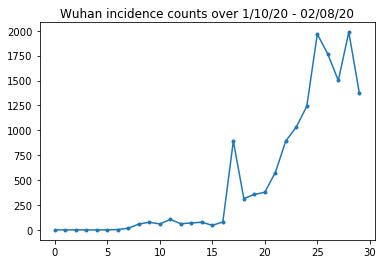

In [ ]:
plt.plot(raw_incidence.Wuhan, '.-')
plt.title('Wuhan incidence counts over 1/10/20 - 02/08/20')
plt.show()

지금까지는 그런대로 잘됐습니다. 이제 초기 인구가 계산됩니다.

In [ ]:
raw_population

City  Population
0                  Beijing  21540000.0
1                  Tianjin  11760000.0
2             Shijiazhuang  10151200.0
3                 Tangshan   7843600.0
4              Qinhuangdao   3094600.0
5                   Handan   9492800.0
6                   Xintai   7319900.0
7                  Baoding  10425300.0
8              Zhangjiakou   4425100.0
9                  Chengde   3531800.0
10                Cangzhou   7505500.0
11                Langfang   4615000.0
12                Hengshui   4453100.0
13                 Taiyuan   4421400.0
14                  Datong   3456000.0
15                Yangquan   1414400.0
16                Changzhi   3468200.0
17                Jincheng   2343100.0
18                Shuozhou   1781200.0
19                Jinzhong   3381600.0
20                Yuncheng   5359600.0
21                 Xinzhou   3171200.0
22                  Linfen   4500300.0
23                 Lvliang   3885600.0
24               Huhehaote   2437900.0
25                  Baotou   2297400.0
26                   Wuhai    434900.0
27                 Chifeng   4518000.0
28                Tongliao   3083500.0
29                Eerduosi   2078400.0
..                     ...         ...
345                Urumuqi   2330000.0
346               Kelamayi    270000.0
347                Tulufan    590000.0
348                   Hami    550000.0
349                Changji   1590000.0
350      Bozhou (Xinjiang)    470000.0
351      Bazhou (Xinjiang)   1170000.0
352                  Akesu   2260000.0
353                 Kezhou    470000.0
354                  Kashi   3650000.0
355      Hetian (Xinjiang)   1800000.0
356                   Yili   2600000.0
357                Tacheng    990000.0
358                 Aletai    640000.0
359                Shihezi    660000.0
360                 Ala'er    326800.0
361              Tumushuke    255600.0
362     Wujiaqu (Xinjiang)    125600.0
363                 Beitun     80000.0
364  Wujiaqushi (Xinjiang)    125600.0
365             Tiemenguan     50000.0
366               Shuanghe     53800.0
367               Kekedala     75000.0
368                 Taiwan  23580000.0
369               Hongkong   7450000.0
370                  Macao    630000.0
371  Hetianxian (Xinjiang)    360000.0
372                   Moyu    646200.0
373                 Yutian    289500.0
374                  Gejiu    472000.0

[375 rows x 2 columns]

어떤 입국이 우한인지도 확인하고 기록합니다.

In [ ]:
raw_population['City'][169]

'Wuhan'

In [ ]:
WUHAN_IDX = 169

여기에 서로 다른 도시 간의 이동성 매트릭스를 볼 수 있습니다. 이것은 처음 14일 동안 여러 도시 사이를 이동하는 사람들의 수를 간접적으로 나타내줍니다. Tencent가 2018년 설날 시즌에 제공한 GPS 기록을 기반으로 도출한 자료입니다. Li 등은 2020년 시즌 동안 이동성을 일부 알려지지 않은(추론에 따라 다름) 상수 인자 $\theta$를 곱한 것으로 모델링합니다.

In [ ]:
raw_mobility

Day   Origin      Destination  Mobility Index
0        1  Beijing          Tianjin           17585
1        1  Beijing     Shijiazhuang           21289
2        1  Beijing           Handan           27676
3        1  Beijing          Baoding           19007
4        1  Beijing      Zhangjiakou           20327
5        1  Beijing         Langfang           31180
6        1  Beijing         Ha'erbin           24390
7        1  Beijing         Shanghai           66799
8        1  Beijing          Nanjing           17719
9        1  Beijing         Hangzhou           28536
10       1  Beijing          Wenzhou           16767
11       1  Beijing          Xinyang           17522
12       1  Beijing            Wuhan           32517
13       1  Beijing         Changsha           35671
14       1  Beijing        Chongqing           66639
15       1  Beijing            Xi'an           17088
16       1  Tianjin          Beijing           13942
17       1  Tianjin         Tangshan            6631
18       1  Tianjin           Handan            5140
19       1  Tianjin          Baoding            6398
20       1  Tianjin         Cangzhou            7030
21       1  Tianjin         Langfang            7363
22       1  Tianjin        Changchun            4258
23       1  Tianjin         Ha'erbin           12675
24       1  Tianjin         Shanghai            8698
25       1  Tianjin         Hangzhou            4364
26       1  Tianjin  Fuzhou (Fujian)           14632
27       1  Tianjin           Dezhou            6857
28       1  Tianjin            Wuhan            4669
29       1  Tianjin         Changsha            6579
...    ...      ...              ...             ...
92218   14    Gejiu         Changsha              52
92219   14    Gejiu         Hengyang              42
92220   14    Gejiu          Changde              53
92221   14    Gejiu         Chenzhou              36
92222   14    Gejiu         Yongzhou              42
92223   14    Gejiu        Guangzhou              48
92224   14    Gejiu         Shenzhen              77
92225   14    Gejiu          Huizhou              43
92226   14    Gejiu           Nannig              30
92227   14    Gejiu           Beihai              30
92228   14    Gejiu            Baise              37
92229   14    Gejiu        Chongqing             132
92230   14    Gejiu         Neijiang              47
92231   14    Gejiu       Liupanshui              41
92232   14    Gejiu            Bijie              32
92233   14    Gejiu          Kunming             452
92234   14    Gejiu           Qujing             359
92235   14    Gejiu             Yuxi             170
92236   14    Gejiu         Shaotong              94
92237   14    Gejiu            Pu'er              50
92238   14    Gejiu         Chuxiong              62
92239   14    Gejiu          Wenshan             138
92240   14    Gejiu             Dali              50
92241   14    Gejiu            Xi'an              55
92242   14    Gejiu         Xianyang              38
92243   14    Gejiu          Lanzhou              60
92244   14    Gejiu        Pingliang              73
92245   14    Gejiu           Dongxi             126
92246   14    Gejiu           Xining              31
92247   14    Gejiu           Guyuan              33

[92248 rows x 4 columns]

마지막으로, 이 모든 것을 우리가 소비할 수 있는 numpy 배열로 전처리해 보겠습니다.

In [ ]:
# The given populations are only "initial" because of intercity mobility during
# the holiday season.
initial_population = raw_population['Population'].to_numpy().astype(np.float32)

이동성 데이터를 [L, L, T] 형상의 Tensor로 변환합니다. 여기서 L은 위치 수이고 T는 시간 스텝 수입니다.

In [ ]:
daily_mobility_matrices = []
for i in range(1, 15):
  day_mobility = raw_mobility[raw_mobility['Day'] == i]
  
  # Make a matrix of daily mobilities.
  z = pd.crosstab(
      day_mobility.Origin, 
      day_mobility.Destination, 
      values=day_mobility['Mobility Index'], aggfunc='sum', dropna=False)
  
  # Include every city, even if there are no rows for some in the raw data on
  # some day.  This uses the sort order of `raw_population`.
  z = z.reindex(index=raw_population['City'], columns=raw_population['City'], 
                fill_value=0)
  # Finally, fill any missing entries with 0. This means no mobility.
  z = z.fillna(0)
  daily_mobility_matrices.append(z.to_numpy())

mobility_matrix_over_time = np.stack(daily_mobility_matrices, axis=-1).astype(
    np.float32)

마지막으로, 관찰된 감염을 취하여 [L, T] 테이블을 만듭니다.

In [ ]:
# Remove the date parameter and take the first 14 days.
observed_daily_infectious_count = raw_incidence.to_numpy()[:14, 1:]
observed_daily_infectious_count = np.transpose(
    observed_daily_infectious_count).astype(np.float32)

그리고 원하는 형상을 얻었는지 다시 확인합니다. 참고로 여기서는 14일 동안 375개 도시에 대해 작업하고 있습니다.

In [ ]:
print('Mobility Matrix over time should have shape (375, 375, 14): {}'.format(
    mobility_matrix_over_time.shape))
print('Observed Infectious should have shape (375, 14): {}'.format(
    observed_daily_infectious_count.shape))
print('Initial population should have shape (375): {}'.format(
    initial_population.shape))

Mobility Matrix over time should have shape (375, 375, 14): (375, 375, 14)
Observed Infectious should have shape (375, 14): (375, 14)
Initial population should have shape (375): (375,)


## 상태 및 매개변수 정의

모델 정의를 시작하겠습니다. 우리가 재현하고 있는 모델은 [SEIR 모델](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model)의 변형입니다. 이 경우 다음과 같은 시변 상태가 존재합니다.

- $S$: 각 도시에서 질병에 감수성이 있는 사람들의 수.
- $E$: 각 도시에서 질병에 노출되었지만 아직 감염성이 없는 사람들의 수. 생물학적으로 이것은 노출된 모든 사람들이 결국 감염된다는 점에서 질병에 걸리는 것과 같습니다.
- $I^u$: 각 도시에서 감염성이 있지만 문서화되지 않은 사람의 수. 모델에서 이것은 실제로 "절대 문서화되지 않음"을 의미합니다.
- $I^r$: 각 도시에서 감염되고 그에 따라 문서화된 사람의 수. Li 등은 보고 지연을 모델로 하므로 $I^r$는 실제로 "미래의 어느 시점에서 문서화할 수 있을 만큼 충분히 심각한 사례"와 같은 것에 해당합니다.

아래에서 볼 수 있듯이 EAKF(Ensemble-adjusted Kalman Filter)를 시간에 앞서 실행함으로써 이러한 상태를 추론할 것입니다. EAKF의 상태 벡터는 이러한 각각의 양에 대해 하나의 도시가 인덱싱된 벡터입니다.

모델에는 다음과 같은 추론 가능한 전역 시불변 매개변수가 있습니다.

- $\beta$: 문서화된 감염자에 의한 전파율.
- $\mu$: 문서화되지 않은 감염자에 의한 상대적 전파율. 이것은 $\mu \beta$ 적을 통해 작동합니다.
- $\theta$: 도시 간 이동성 인자. 이것은 이동성 데이터의 과소보고(및 2018년부터 2020년까지의 인구 증가)를 수정하는 1보다 큰 인자입니다.
- $Z$: 평균 잠복기(즉, "노출된" 상태의 시간).
- $\alpha$: 이것은 (결국) 문서화될 만큼 충분히 심각한 감염의 비율입니다.
- $D$: 평균 감염 기간(즉, "전염성" 상태에 있는 시간).

상태에 대한 EAKF 주변의 반복 필터링 루프를 사용하여 이러한 매개변수에 대한 포인트 추정치를 추론할 것입니다.

이 모델은 추론되지 않은 상수에도 의존합니다.

- $M$: 도시 간 이동성 매트릭스. 이것은 시간에 따라 달라지며 주어진 것으로 추정됩니다. 도시 간의 실제 인구 이동을 제공하기 위해 추론된 매개변수 $\theta$에 의해 크기가 조정된다는 것을 기억하십시오.
- $N$: 각 도시의 총 인구 수. 초기 모집단은 주어진 대로 취하며 모집단의 시간-변동은 이동성 수 $\theta M$로부터 계산됩니다.


먼저, 상태와 매개변수를 유지하기 위한 몇 가지 데이터 구조를 제공합니다.


In [ ]:
SEIRComponents = collections.namedtuple(
  typename='SEIRComponents',
  field_names=[
    'susceptible',              # S
    'exposed',                  # E
    'documented_infectious',    # I^r
    'undocumented_infectious',  # I^u
    # This is the count of new cases in the "documented infectious" compartment.
    # We need this because we will introduce a reporting delay, between a person
    # entering I^r and showing up in the observable case count data.
    # This can't be computed from the cumulative `documented_infectious` count,
    # because some portion of that population will move to the 'recovered'
    # state, which we aren't tracking explicitly.
    'daily_new_documented_infectious'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'documented_infectious_tx_rate',             # Beta
      'undocumented_infectious_tx_relative_rate',  # Mu
      'intercity_underreporting_factor',           # Theta
      'average_latency_period',                    # Z
      'fraction_of_documented_infections',         # Alpha
      'average_infection_duration'                 # D
    ]
)

또한 매개변수 값에 대해 Li 등의 경계를 코딩합니다.

In [ ]:
PARAMETER_LOWER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=0.8,
    undocumented_infectious_tx_relative_rate=0.2,
    intercity_underreporting_factor=1.,
    average_latency_period=2.,
    fraction_of_documented_infections=0.02,
    average_infection_duration=2.
)

PARAMETER_UPPER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=1.5,
    undocumented_infectious_tx_relative_rate=1.,
    intercity_underreporting_factor=1.75,
    average_latency_period=5.,
    fraction_of_documented_infections=1.,
    average_infection_duration=5.
)

## SEIR 역학

여기에서 매개변수와 상태 간의 관계를 정의합니다.

Li 등(보충 자료, 수식 1-5)의 시간 역학 방정식은 다음과 같습니다.

$\frac{dS_i}{dt} = -\beta \frac{S_i I_i^r}{N_i} - \mu \beta \frac{S_i I_i^u}{N_i} + \theta \sum_k \frac{M_{ij} S_j}{N_j - I_j^r} - + \theta \sum_k \frac{M_{ji} S_j}{N_i - I_i^r}$

$\frac{dE_i}{dt} = \beta \frac{S_i I_i^r}{N_i} + \mu \beta \frac{S_i I_i^u}{N_i} -\frac{E_i}{Z} + \theta \sum_k \frac{M_{ij} E_j}{N_j - I_j^r} - + \theta \sum_k \frac{M_{ji} E_j}{N_i - I_i^r}$

$\frac{dI^r_i}{dt} = \alpha \frac{E_i}{Z} - \frac{I_i^r}{D}$

$\frac{dI^u_i}{dt} = (1 - \alpha) \frac{E_i}{Z} - \frac{I_i^u}{D} + \theta \sum_k \frac{M_{ij} I_j^u}{N_j - I_j^r} - + \theta \sum_k \frac{M_{ji} I^u_j}{N_i - I_i^r}$

$N_i = N_i + \theta \sum_j M_{ij} - \theta \sum_j M_{ji}$

참고로 $i$ 및 $j$ 아래 첨자는 도시를 인덱싱합니다. 이 방정식은 다음을 통해 질병의 시간 경과를 모델링합니다.

- 더 많은 감염을 유발하는 전염성 감염자와의 접촉
- "노출" 상태에서 "전염성" 상태 중 하나로의 질병 진행
- "전염성" 상태에서 회복으로의 질병 진행; 모델링된 모집단으로부터 제거를 통해 이를 모델링합니다.
- 노출되거나 문서화되지 않은 감염자를 포함한 도시 간 이동성
- 도시 간 이동성을 통한 일일 도시 인구의 시간 변화

Li 등에 따르면 결국 보고될 만큼 심각한 사례를 가진 사람들이 도시 사이를 이동하지 않는다고 가정합니다.

또한 Li 등에 따르면 이러한 역학을 항별 포아송 노이즈의 대상으로 취급합니다. 즉, 각 항은 실제로 실제 변화를 제공하는 샘플인 포아송의 비율입니다. 포아송 노이즈는 포아송 샘플을 빼도(덧셈과 반대) 포아송 분포 결과가 나오지 않기 때문에 항에 따라 다릅니다.

고전적인 4차 Runge-Kutta 적분기를 사용하여 이러한 역학을 전개시킬 것이지만 먼저 이를 계산하는 함수(포아송 노이즈 샘플링 포함)를 정의하겠습니다.

In [ ]:
def sample_state_deltas(
    state, population, mobility_matrix, params, seed, is_deterministic=False):
  """Computes one-step change in state, including Poisson sampling.
  
  Note that this is coded to support vectorized evaluation on arbitrary-shape
  batches of states.  This is useful, for example, for running multiple
  independent replicas of this model to compute credible intervals for the
  parameters.  We refer to the arbitrary batch shape with the conventional
  `B` in the parameter documentation below.  This function also, of course,
  supports broadcasting over the batch shape.

  Args:
    state: A `SEIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the current disease state.
    population: A Tensor of shape B + [num_locations] giving the current city
      populations.
    mobility_matrix: A Tensor of shape B + [num_locations, num_locations] giving
      the current baseline inter-city mobility.
    params: A `ModelParams` tuple with fields Tensors of shape B giving the
      global parameters for the current EAKF run.
    seed: Initial entropy for pseudo-random number generation.  The Poisson
      sampling is repeatable by supplying the same seed.
    is_deterministic: A `bool` flag to turn off Poisson sampling if desired.

  Returns:
    delta: A `SEIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the one-day changes in the state, according
      to equations 1-4 above (including Poisson noise per Li et al).
  """
  undocumented_infectious_fraction = state.undocumented_infectious / population
  documented_infectious_fraction = state.documented_infectious / population

  # Anyone not documented as infectious is considered mobile
  mobile_population = (population - state.documented_infectious)
  def compute_outflow(compartment_population):
    raw_mobility = tf.linalg.matvec(
        mobility_matrix, compartment_population / mobile_population)
    return params.intercity_underreporting_factor * raw_mobility
  def compute_inflow(compartment_population):
    raw_mobility = tf.linalg.matmul(
        mobility_matrix,
        (compartment_population / mobile_population)[..., tf.newaxis],
        transpose_a=True)
    return params.intercity_underreporting_factor * tf.squeeze(
        raw_mobility, axis=-1)

  # Helper for sampling the Poisson-variate terms.
  seeds = samplers.split_seed(seed, n=11)
  if is_deterministic:
    def sample_poisson(rate):
      return rate
  else:
    def sample_poisson(rate):
      return tfd.Poisson(rate=rate).sample(seed=seeds.pop())

  # Below are the various terms called U1-U12 in the paper. We combined the
  # first two, which should be fine; both are poisson so their sum is too, and
  # there's no risk (as there could be in other terms) of going negative.
  susceptible_becoming_exposed = sample_poisson(
      state.susceptible *
      (params.documented_infectious_tx_rate *
       documented_infectious_fraction +
       (params.undocumented_infectious_tx_relative_rate *
        params.documented_infectious_tx_rate) *
       undocumented_infectious_fraction))  # U1 + U2

  susceptible_population_inflow = sample_poisson(
      compute_inflow(state.susceptible))  # U3
  susceptible_population_outflow = sample_poisson(
      compute_outflow(state.susceptible))  # U4

  exposed_becoming_documented_infectious = sample_poisson(
      params.fraction_of_documented_infections *
      state.exposed / params.average_latency_period)  # U5
  exposed_becoming_undocumented_infectious = sample_poisson(
      (1 - params.fraction_of_documented_infections) *
      state.exposed / params.average_latency_period)  # U6

  exposed_population_inflow = sample_poisson(
      compute_inflow(state.exposed))  # U7
  exposed_population_outflow = sample_poisson(
      compute_outflow(state.exposed))  # U8

  documented_infectious_becoming_recovered = sample_poisson(
      state.documented_infectious /
      params.average_infection_duration)  # U9
  undocumented_infectious_becoming_recovered = sample_poisson(
      state.undocumented_infectious /
      params.average_infection_duration)  # U10

  undocumented_infectious_population_inflow = sample_poisson(
      compute_inflow(state.undocumented_infectious))  # U11
  undocumented_infectious_population_outflow = sample_poisson(
      compute_outflow(state.undocumented_infectious))  # U12

  # The final state_deltas
  return SEIRComponents(
      # Equation [1]
      susceptible=(-susceptible_becoming_exposed +
                   susceptible_population_inflow +
                   -susceptible_population_outflow),
      # Equation [2]
      exposed=(susceptible_becoming_exposed +
               -exposed_becoming_documented_infectious +
               -exposed_becoming_undocumented_infectious +
               exposed_population_inflow +
               -exposed_population_outflow),
      # Equation [3]
      documented_infectious=(
          exposed_becoming_documented_infectious +
          -documented_infectious_becoming_recovered),
      # Equation [4]
      undocumented_infectious=(
          exposed_becoming_undocumented_infectious +
          -undocumented_infectious_becoming_recovered +
          undocumented_infectious_population_inflow +
          -undocumented_infectious_population_outflow),
      # New to-be-documented infectious cases, subject to the delayed
      # observation model.
      daily_new_documented_infectious=exposed_becoming_documented_infectious)

여기 적분기가 있습니다. 이것은 Runge-Kutta 메서드가 호출하는 각 부분 스텝에서 독립적인 포아송 노이즈를 얻기 위해 PRNG 시드를 `sample_state_deltas` 함수로 전달하는 것을 제외하고는 완전히 표준입니다.

In [ ]:
@tf.function(autograph=False)
def rk4_one_step(state, population, mobility_matrix, params, seed):
  """Implement one step of RK4, wrapped around a call to sample_state_deltas."""
  # One seed for each RK sub-step
  seeds = samplers.split_seed(seed, n=4)

  deltas = tf.nest.map_structure(tf.zeros_like, state)
  combined_deltas = tf.nest.map_structure(tf.zeros_like, state)

  for a, b in zip([1., 2, 2, 1.], [6., 3., 3., 6.]):
    next_input = tf.nest.map_structure(
        lambda x, delta, a=a: x + delta / a, state, deltas)
    deltas = sample_state_deltas(
        next_input,
        population,
        mobility_matrix,
        params,
        seed=seeds.pop(), is_deterministic=False)
    combined_deltas = tf.nest.map_structure(
        lambda x, delta, b=b: x + delta / b, combined_deltas, deltas)

  return tf.nest.map_structure(
      lambda s, delta: s + tf.round(delta),
      state, combined_deltas)

## 초기화

여기에서는 논문의 초기화 체계를 구현합니다.

Li 등에 따라 우리의 추론 방식은 반복 필터링 외부 루프(IF-EAKF)로 둘러싸인 앙상블 조정 Kalman 필터 내부 루프가 될 것입니다. 계산적으로 이것은 세 가지 종류의 초기화가 필요함을 의미합니다.

- 내부 EAKF의 초기 상태
- 첫 번째 EAKF의 초기 매개변수이기도 한 외부 IF의 초기 매개변수
- 첫 번째가 아닌 각 EAKF의 초기 매개변수 역할을 하는, 하나의 IF 반복에서 다음 반복으로의 매개변수 업데이트


In [ ]:
def initialize_state(num_particles, num_batches, seed):
  """Initialize the state for a batch of EAKF runs.
  
  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    state: A `SEIRComponents` tuple with Tensors of shape [num_particles,
      num_batches, num_cities] giving the initial conditions in each
      city, in each filter particle, in each batch member.
  """
  num_cities = mobility_matrix_over_time.shape[-2]
  state_shape = [num_particles, num_batches, num_cities]
  susceptible = initial_population * np.ones(state_shape, dtype=np.float32)
  documented_infectious = np.zeros(state_shape, dtype=np.float32)
  daily_new_documented_infectious = np.zeros(state_shape, dtype=np.float32)

  # Following Li et al, initialize Wuhan with up to 2000 people exposed
  # and another up to 2000 undocumented infectious.
  rng = np.random.RandomState(seed[0] % (2**31 - 1))
  wuhan_exposed = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)
  wuhan_undocumented_infectious = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)
 
  # Also following Li et al, initialize cities adjacent to Wuhan with three
  # days' worth of additional exposed and undocumented-infectious cases,
  # as they may have traveled there before the beginning of the modeling
  # period.
  exposed = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_exposed[
          ..., np.newaxis] / initial_population[WUHAN_IDX]
  undocumented_infectious = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_undocumented_infectious[
          ..., np.newaxis] / initial_population[WUHAN_IDX]

  exposed[..., WUHAN_IDX] = wuhan_exposed
  undocumented_infectious[..., WUHAN_IDX] = wuhan_undocumented_infectious

  # Following Li et al, we do not remove the initial exposed and infectious
  # persons from the susceptible population.
  return SEIRComponents(
      susceptible=tf.constant(susceptible),
      exposed=tf.constant(exposed),
      documented_infectious=tf.constant(documented_infectious),
      undocumented_infectious=tf.constant(undocumented_infectious),
      daily_new_documented_infectious=tf.constant(daily_new_documented_infectious))
  
def initialize_params(num_particles, num_batches, seed):
  """Initialize the global parameters for the entire inference run.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the first batch of EAKF runs.
  """
  # We have 6 parameters. We'll initialize with a Sobol sequence,
  # covering the hyper-rectangle defined by our parameter limits.
  halton_sequence = tfp.mcmc.sample_halton_sequence(
      dim=6, num_results=num_particles * num_batches, seed=seed)
  halton_sequence = tf.reshape(
      halton_sequence, [num_particles, num_batches, 6])
  halton_sequences = tf.nest.pack_sequence_as(
      PARAMETER_LOWER_BOUNDS, tf.split(
          halton_sequence, num_or_size_splits=6, axis=-1))
  def interpolate(minval, maxval, h):
    return (maxval - minval) * h + minval
  return tf.nest.map_structure(
      interpolate,
      PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS, halton_sequences)

def update_params(num_particles, num_batches,
                  prev_params, parameter_variance, seed):
  """Update the global parameters between EAKF runs.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    prev_params: A `ModelParams` tuple of the parameters used for the previous
      EAKF run.
    parameter_variance: A `ModelParams` tuple specifying how much to drift
      each parameter.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the next batch of EAKF runs.
  """
  # Initialize near the previous set of parameters. This is the first step
  # in Iterated Filtering.
  seeds = tf.nest.pack_sequence_as(
      prev_params, samplers.split_seed(seed, n=len(prev_params)))
  return tf.nest.map_structure(
      lambda x, v, seed: x + tf.math.sqrt(v) * tf.random.stateless_normal([
          num_particles, num_batches, 1], seed=seed),
      prev_params, parameter_variance, seeds)

## 지연

이 모델의 중요한 특징 중 하나는 감염이 시작된 것보다 늦게 보고된다는 사실을 명시적으로 고려한다는 것입니다. 즉, $t$일에 $E$ 구간에서 $I^r$ 구간으로 이동한 사람이 어느 정도 시간이 지날 때까지 관찰 가능한 보고 사례 수에 나타나지 않을 수 있습니다.

지연이 감마 분포라고 가정합니다. Li 등에 따르면 형상에 1.85를 사용하고 9일의 평균 보고 지연을 생성하기 위해 비율을 매개변수화합니다.

In [ ]:
def raw_reporting_delay_distribution(gamma_shape=1.85, reporting_delay=9.):
  return tfp.distributions.Gamma(
      concentration=gamma_shape, rate=gamma_shape / reporting_delay)

우리의 관찰은 불연속적이므로 원시(연속) 지연을 가장 가까운 날까지 반올림합니다. 또한 유한한 데이터 범위를 가지고 있으므로 한 사람에 대한 지연 분포는 남은 일 수 동안 범주형입니다. 따라서 대신 다항 지연 확률을 미리 계산하여 $O(I^r)$ 감마를 샘플링하는 것보다 도시별 예측 관측치를 더 효율적으로 계산할 수 있습니다.

In [ ]:
def reporting_delay_probs(num_timesteps, gamma_shape=1.85, reporting_delay=9.):
  gamma_dist = raw_reporting_delay_distribution(gamma_shape, reporting_delay)
  multinomial_probs = [gamma_dist.cdf(1.)]
  for k in range(2, num_timesteps + 1):
    multinomial_probs.append(gamma_dist.cdf(k) - gamma_dist.cdf(k - 1))
  # For samples that are larger than T.
  multinomial_probs.append(gamma_dist.survival_function(num_timesteps))
  multinomial_probs = tf.stack(multinomial_probs)
  return multinomial_probs

다음은 새로운 일일 문서화 감염 수에 이러한 지연을 실제로 적용하는 코드입니다.

In [ ]:
def delay_reporting(
    daily_new_documented_infectious, num_timesteps, t, multinomial_probs, seed):
  # This is the distribution of observed infectious counts from the current
  # timestep.

  raw_delays = tfd.Multinomial(
      total_count=daily_new_documented_infectious,
      probs=multinomial_probs).sample(seed=seed)

  # The last bucket is used for samples that are out of range of T + 1. Thus
  # they are not going to be observable in this model.
  clipped_delays = raw_delays[..., :-1]

  # We can also remove counts that are such that t + i >= T.
  clipped_delays = clipped_delays[..., :num_timesteps - t]
  # We finally shift everything by t. That means prepending with zeros.
  return tf.concat([
      tf.zeros(
          tf.concat([
              tf.shape(clipped_delays)[:-1], [t]], axis=0),
          dtype=clipped_delays.dtype),
      clipped_delays], axis=-1)

## 추론

먼저, 추론을 위한 몇 가지 데이터 구조를 정의합니다.

특히, 우리는 추론을 수행하는 동안 상태와 매개변수를 함께 패키징하는 반복 필터링이 필요합니다. 그래서 `ParameterStatePair` 객체를 정의할 것입니다.

또한 모든 부가 정보를 모델에 패키징하려고 합니다.

In [ ]:
ParameterStatePair = collections.namedtuple(
    'ParameterStatePair', ['state', 'params'])

# Info that is tracked and mutated but should not have inference performed over.
SideInfo = collections.namedtuple(
    'SideInfo', [
        # Observations at every time step.
        'observations_over_time',
        'initial_population',
        'mobility_matrix_over_time',
        'population',
        # Used for variance of measured observations.
        'actual_reported_cases',
        # Pre-computed buckets for the multinomial distribution.
        'multinomial_probs',
        'seed',
    ])

# Cities can not fall below this fraction of people
MINIMUM_CITY_FRACTION = 0.6

# How much to inflate the covariance by.
INFLATION_FACTOR = 1.1

INFLATE_FN = tfes.inflate_by_scaled_identity_fn(INFLATION_FACTOR)

다음은 Ensemble Kalman 필터에 대해 패키징된 완전한 관찰 모델입니다.

흥미로운 특징은 보고 지연(이전과 같이 계산됨)입니다. 업스트림 모델은 각 시간 스텝에서 각 도시에 대해 `daily_new_documented_infectious`를 방출합니다.

In [ ]:
# We observe the observed infections.
def observation_fn(t, state_params, extra):
  """Generate reported cases.
  
  Args:
    state_params: A `ParameterStatePair` giving the current parameters
      and state.
    t: Integer giving the current time.
    extra: A `SideInfo` carrying auxiliary information.

  Returns:
    observations: A Tensor of predicted observables, namely new cases
      per city at time `t`.
    extra: Update `SideInfo`.
  """
  # Undo padding introduced in `inference`.
  daily_new_documented_infectious = state_params.state.daily_new_documented_infectious[..., 0]
  # Number of people that we have already committed to become
  # observed infectious over time.
  # shape: batch + [num_particles, num_cities, time]
  observations_over_time = extra.observations_over_time
  num_timesteps = observations_over_time.shape[-1]

  seed, new_seed = samplers.split_seed(extra.seed, salt='reporting delay')
  
  daily_delayed_counts = delay_reporting(
      daily_new_documented_infectious, num_timesteps, t,
      extra.multinomial_probs, seed)
  observations_over_time = observations_over_time + daily_delayed_counts

  extra = extra._replace(
      observations_over_time=observations_over_time,
      seed=new_seed)

  # Actual predicted new cases, re-padded.
  adjusted_observations = observations_over_time[..., t][..., tf.newaxis]
  # Finally observations have variance that is a function of the true observations:
  return tfd.MultivariateNormalDiag(
      loc=adjusted_observations,
      scale_diag=tf.math.maximum(
          2., extra.actual_reported_cases[..., t][..., tf.newaxis] / 2.)), extra

여기에서 전환 역학을 정의합니다. 의미론적 작업은 이미 완료했습니다. 여기에서는 EAKF 프레임워크에 대해서만 패키지화하고 Li 등에 따라 도시 인구가 너무 작아지는 것을 방지하기 위해 클립을 잘라냅니다.

In [ ]:
def transition_fn(t, state_params, extra):
  """SEIR dynamics.

  Args:
    state_params: A `ParameterStatePair` giving the current parameters
      and state.
    t: Integer giving the current time.
    extra: A `SideInfo` carrying auxiliary information.

  Returns:
    state_params: A `ParameterStatePair` predicted for the next time step.
    extra: Updated `SideInfo`.
  """
  mobility_t = extra.mobility_matrix_over_time[..., t]
  new_seed, rk4_seed = samplers.split_seed(extra.seed, salt='Transition')
  new_state = rk4_one_step(
      state_params.state,
      extra.population,
      mobility_t,
      state_params.params,
      seed=rk4_seed)

  # Make sure population doesn't go below MINIMUM_CITY_FRACTION.
  new_population = (
      extra.population + state_params.params.intercity_underreporting_factor * (
          # Inflow
          tf.reduce_sum(mobility_t, axis=-2) - 
          # Outflow
          tf.reduce_sum(mobility_t, axis=-1)))
  new_population = tf.where(
      new_population < MINIMUM_CITY_FRACTION * extra.initial_population,
      extra.initial_population * MINIMUM_CITY_FRACTION,
      new_population)

  extra = extra._replace(population=new_population, seed=new_seed)

  # The Ensemble Kalman Filter code expects the transition function to return a distribution.
  # As the dynamics and noise are encapsulated above, we construct a `JointDistribution` that when
  # sampled, returns the values above.

  new_state = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), new_state))
  params = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), state_params.params))
  
  state_params = tfd.JointDistributionNamed(
      model=ParameterStatePair(state=new_state, params=params))

  return state_params, extra

마지막으로, 추론 방법을 정의합니다. 이것은 두 개의 루프로, 외부 루프는 반복 필터링이고 내부 루프는 앙상블 조정 Kalman 필터링입니다.

In [ ]:
# Use tf.function to speed up EAKF prediction and updates.
ensemble_kalman_filter_predict = tf.function(
    tfes.ensemble_kalman_filter_predict, autograph=False)
ensemble_adjustment_kalman_filter_update = tf.function(
    tfes.ensemble_adjustment_kalman_filter_update, autograph=False)

def inference(
    num_ensembles,
    num_batches,
    num_iterations,
    actual_reported_cases,
    mobility_matrix_over_time,
    seed=None,
    # This is how much to reduce the variance by in every iterative
    # filtering step.
    variance_shrinkage_factor=0.9,
    # Days before infection is reported.
    reporting_delay=9.,
    # Shape parameter of Gamma distribution.
    gamma_shape_parameter=1.85):
  """Inference for the Shaman, et al. model.

  Args:
    num_ensembles: Number of particles to use for EAKF.
    num_batches: Number of batches of IF-EAKF to run.
    num_iterations: Number of iterations to run iterative filtering.
    actual_reported_cases: `Tensor` of shape `[L, T]` where `L` is the number
      of cities, and `T` is the timesteps.
    mobility_matrix_over_time: `Tensor` of shape `[L, L, T]` which specifies the
      mobility between locations over time.
    variance_shrinkage_factor: Python `float`. How much to reduce the
      variance each iteration of iterated filtering.
    reporting_delay: Python `float`. How many days before the infection
      is reported.
    gamma_shape_parameter: Python `float`. Shape parameter of Gamma distribution
      of reporting delays.

  Returns:
    result: A `ModelParams` with fields Tensors of shape [num_batches],
      containing the inferred parameters at the final iteration.
  """
  print('Starting inference.')
  num_timesteps = actual_reported_cases.shape[-1]
  params_per_iter = []

  multinomial_probs = reporting_delay_probs(
      num_timesteps, gamma_shape_parameter, reporting_delay)

  seed = samplers.sanitize_seed(seed, salt='Inference')

  for i in range(num_iterations):
    start_if_time = time.time()
    seeds = samplers.split_seed(seed, n=4, salt='Initialize')
    if params_per_iter:
      parameter_variance = tf.nest.map_structure(
          lambda minval, maxval: variance_shrinkage_factor ** (
              2 * i) * (maxval - minval) ** 2 / 4.,
          PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)
      params_t = update_params(
          num_ensembles,
          num_batches,
          prev_params=params_per_iter[-1],
          parameter_variance=parameter_variance,
          seed=seeds.pop())
    else:
      params_t = initialize_params(num_ensembles, num_batches, seed=seeds.pop())

    state_t = initialize_state(num_ensembles, num_batches, seed=seeds.pop())
    population_t = sum(x for x in state_t)
    observations_over_time = tf.zeros(
        [num_ensembles,
         num_batches,
         actual_reported_cases.shape[0], num_timesteps])

    extra = SideInfo(
        observations_over_time=observations_over_time,
        initial_population=tf.identity(population_t),
        mobility_matrix_over_time=mobility_matrix_over_time,
        population=population_t,
        multinomial_probs=multinomial_probs,
        actual_reported_cases=actual_reported_cases,
        seed=seeds.pop())

    # Clip states
    state_t = clip_state(state_t, population_t)
    params_t = clip_params(params_t, seed=seeds.pop())

    # Accrue the parameter over time. We'll be averaging that
    # and using that as our MLE estimate.
    params_over_time = tf.nest.map_structure(
        lambda x: tf.identity(x), params_t)

    state_params = ParameterStatePair(state=state_t, params=params_t)

    eakf_state = tfes.EnsembleKalmanFilterState(
        step=tf.constant(0), particles=state_params, extra=extra)

    for j in range(num_timesteps):
      seeds = samplers.split_seed(eakf_state.extra.seed, n=3)
      
      extra = extra._replace(seed=seeds.pop())
    
      # Predict step.

      # Inflate and clip.
      new_particles = INFLATE_FN(eakf_state.particles)
      state_t = clip_state(new_particles.state, eakf_state.extra.population)
      params_t = clip_params(new_particles.params, seed=seeds.pop())
      eakf_state = eakf_state._replace(
          particles=ParameterStatePair(params=params_t, state=state_t))

      eakf_predict_state = ensemble_kalman_filter_predict(eakf_state, transition_fn)

      # Clip the state and particles.
      state_params = eakf_predict_state.particles
      state_t = clip_state(
          state_params.state, eakf_predict_state.extra.population)
      state_params = ParameterStatePair(state=state_t, params=state_params.params)

      # We preprocess the state and parameters by affixing a 1 dimension. This is because for
      # inference, we treat each city as independent. We could also introduce localization by
      # considering cities that are adjacent.
      state_params = tf.nest.map_structure(lambda x: x[..., tf.newaxis], state_params)
      eakf_predict_state = eakf_predict_state._replace(particles=state_params)

      # Update step.
      
      eakf_update_state = ensemble_adjustment_kalman_filter_update(
          eakf_predict_state,
          actual_reported_cases[..., j][..., tf.newaxis],
          observation_fn)
      
      state_params = tf.nest.map_structure(
          lambda x: x[..., 0], eakf_update_state.particles)

      # Clip to ensure parameters / state are well constrained.
      state_t = clip_state(
          state_params.state, eakf_update_state.extra.population)
      
      # Finally for the parameters, we should reduce over all updates. We get
      # an extra dimension back so let's do that.
      params_t = tf.nest.map_structure(
          lambda x, y: x + tf.reduce_sum(y[..., tf.newaxis] - x, axis=-2, keepdims=True),
          eakf_predict_state.particles.params, state_params.params)
      params_t = clip_params(params_t, seed=seeds.pop())
      params_t = tf.nest.map_structure(lambda x: x[..., 0], params_t)

      state_params = ParameterStatePair(state=state_t, params=params_t)
      eakf_state = eakf_update_state
      eakf_state = eakf_state._replace(particles=state_params)

      # Flatten and collect the inferred parameter at time step t.
      params_over_time = tf.nest.map_structure(
          lambda s, x: tf.concat([s, x], axis=-1), params_over_time, params_t)

    est_params = tf.nest.map_structure(
        # Take the average over the Ensemble and over time.
        lambda x: tf.math.reduce_mean(x, axis=[0, -1])[..., tf.newaxis],
        params_over_time)
    params_per_iter.append(est_params)
    print('Iterated Filtering {} / {} Ran in: {:.2f} seconds'.format(
        i, num_iterations, time.time() - start_if_time))

  return tf.nest.map_structure(
      lambda x: tf.squeeze(x, axis=-1), params_per_iter[-1])

최종 세부 사항: 매개변수와 상태를 클리핑하는 과정으로서 이것들이 범위 내에 들어오고 음수가 아니도록 합니다.

In [ ]:
def clip_state(state, population):
  """Clip state to sensible values."""
  state = tf.nest.map_structure(
      lambda x: tf.where(x < 0, 0., x), state)

  # If S > population, then adjust as well.
  susceptible = tf.where(state.susceptible > population, population, state.susceptible)
  return SEIRComponents(
      susceptible=susceptible,
      exposed=state.exposed,
      documented_infectious=state.documented_infectious,
      undocumented_infectious=state.undocumented_infectious,
      daily_new_documented_infectious=state.daily_new_documented_infectious)

def clip_params(params, seed):
  """Clip parameters to bounds."""
  def _clip(p, minval, maxval):
    return tf.where(
        p < minval,
        minval * (1. + 0.1 * tf.random.stateless_uniform(p.shape, seed=seed)),
        tf.where(p > maxval,
                 maxval * (1. - 0.1 * tf.random.stateless_uniform(
                     p.shape, seed=seed)), p))
  params = tf.nest.map_structure(
      _clip, params, PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)

  return params

## 모두 함께 실행

In [ ]:
# Let's sample the parameters.
#
# NOTE: Li et al. run inference 1000 times, which would take a few hours.
# Here we run inference 30 times (in a single, vectorized batch).
best_parameters = inference(
    num_ensembles=300,
    num_batches=30,
    num_iterations=10,
    actual_reported_cases=observed_daily_infectious_count,
    mobility_matrix_over_time=mobility_matrix_over_time)

Starting inference.
Iterated Filtering 0 / 10 Ran in: 26.65 seconds
Iterated Filtering 1 / 10 Ran in: 28.69 seconds
Iterated Filtering 2 / 10 Ran in: 28.06 seconds
Iterated Filtering 3 / 10 Ran in: 28.48 seconds
Iterated Filtering 4 / 10 Ran in: 28.57 seconds
Iterated Filtering 5 / 10 Ran in: 28.35 seconds
Iterated Filtering 6 / 10 Ran in: 28.35 seconds
Iterated Filtering 7 / 10 Ran in: 28.19 seconds
Iterated Filtering 8 / 10 Ran in: 28.58 seconds
Iterated Filtering 9 / 10 Ran in: 28.23 seconds


추론 결과입니다. `num_batches` 독립적인 추론 실행 전반에 걸쳐 변동을 표시하기 위해 모든 전역 매개변수에 대한 최대 가능도 값을 플로팅합니다. 이것은 보충 자료의 표 S1에 해당합니다.

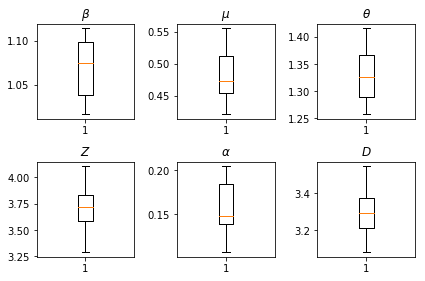

In [ ]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].boxplot(best_parameters.documented_infectious_tx_rate,
                  whis=(2.5,97.5), sym='')
axs[0, 0].set_title(r'$\beta$')

axs[0, 1].boxplot(best_parameters.undocumented_infectious_tx_relative_rate,
                  whis=(2.5,97.5), sym='')
axs[0, 1].set_title(r'$\mu$')

axs[0, 2].boxplot(best_parameters.intercity_underreporting_factor,
                  whis=(2.5,97.5), sym='')
axs[0, 2].set_title(r'$\theta$')

axs[1, 0].boxplot(best_parameters.average_latency_period,
                  whis=(2.5,97.5), sym='')
axs[1, 0].set_title(r'$Z$')

axs[1, 1].boxplot(best_parameters.fraction_of_documented_infections,
                  whis=(2.5,97.5), sym='')
axs[1, 1].set_title(r'$\alpha$')

axs[1, 2].boxplot(best_parameters.average_infection_duration,
                  whis=(2.5,97.5), sym='')
axs[1, 2].set_title(r'$D$')
plt.tight_layout()